In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read CSV
data = pd.read_csv(r'C:\Users\ishan\Downloads\Bulk-Deals-08-02-2024-to-15-02-2024.csv')

# Convert 'Quantity Traded' and 'Trade Price / Wght. Avg. Price' columns to numeric
data['Quantity Traded '] = pd.to_numeric(data['Quantity Traded '].str.replace(',', ''), errors='coerce')
data['Trade Price / Wght. Avg. Price '] = pd.to_numeric(data['Trade Price / Wght. Avg. Price '], errors='coerce')

# Calculate the product of Quantity and Weighted Average Price
data['Quantity * Weighted Avg. Price'] = data['Quantity Traded '] * data['Trade Price / Wght. Avg. Price ']

In [3]:
# Separate into buy and sell DataFrames
data_buy = data[data['Buy / Sell '] == 'BUY']
data_sell = data[data['Buy / Sell '] == 'SELL']

# Group by symbol and calculate the sum of quantity * weighted average price and quantity traded for buy and sell
grouped_data_buy = data_buy.groupby('Symbol ').agg({'Quantity * Weighted Avg. Price': 'sum', 'Quantity Traded ': 'sum'}).reset_index()
grouped_data_sell = data_sell.groupby('Symbol ').agg({'Quantity Traded ': 'sum'}).reset_index()

# Merge the buy and sell DataFrames on the 'Symbol' column
merged_data = pd.merge(grouped_data_buy, grouped_data_sell, on='Symbol ', how='outer', suffixes=('_BUY', '_SELL'))

In [4]:
# Calculate the difference between buy and sell quantities
merged_data = pd.merge(grouped_data_buy, grouped_data_sell, on='Symbol ', how='outer', suffixes=('_BUY', '_SELL'))
filtered_data = merged_data[merged_data['Quantity Traded _BUY'] > merged_data['Quantity Traded _SELL']]
filtered_data['Quantity Difference'] = abs(filtered_data['Quantity Traded _SELL'] - filtered_data['Quantity Traded _BUY'])
print(filtered_data.columns)

Index(['Symbol ', 'Quantity * Weighted Avg. Price', 'Quantity Traded _BUY',
       'Quantity Traded _SELL', 'Quantity Difference'],
      dtype='object')


C:\Users\ishan\AppData\Local\Temp\ipykernel_11576\3440549975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Quantity Difference'] = abs(filtered_data['Quantity Traded _SELL'] - filtered_data['Quantity Traded _BUY'])


In [5]:
# Select the top 20 stocks with a difference equal to or more than 20%
top_n_stocks = 20
top_stocks = filtered_data[filtered_data['Quantity Difference'] >= 0.2 * filtered_data['Quantity Traded _BUY']].sort_values(by='Quantity * Weighted Avg. Price', ascending=False).head(top_n_stocks).reset_index(drop=True)
top_stocks = top_stocks.sort_values(by=['Quantity Difference'], ascending=False)


In [6]:
# Normalize values between 0 and 10
scaler = MinMaxScaler(feature_range=(0, 10))
normalized_values = scaler.fit_transform(top_stocks[['Quantity * Weighted Avg. Price', 'Quantity Traded _BUY', 'Quantity Traded _SELL']])


In [7]:
merged_data['Quantity Difference'] = merged_data['Quantity Traded _BUY'] - merged_data['Quantity Traded _SELL']

In [8]:
top_n_stocks = 20
top_stocks = merged_data[merged_data['Quantity Difference'] >= 0].sort_values(by='Quantity * Weighted Avg. Price', ascending=False).head(top_n_stocks).reset_index(drop=True)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 10))
normalized_values = scaler.fit_transform(top_stocks[['Quantity * Weighted Avg. Price', 'Quantity Traded _BUY', 'Quantity Traded _SELL']])

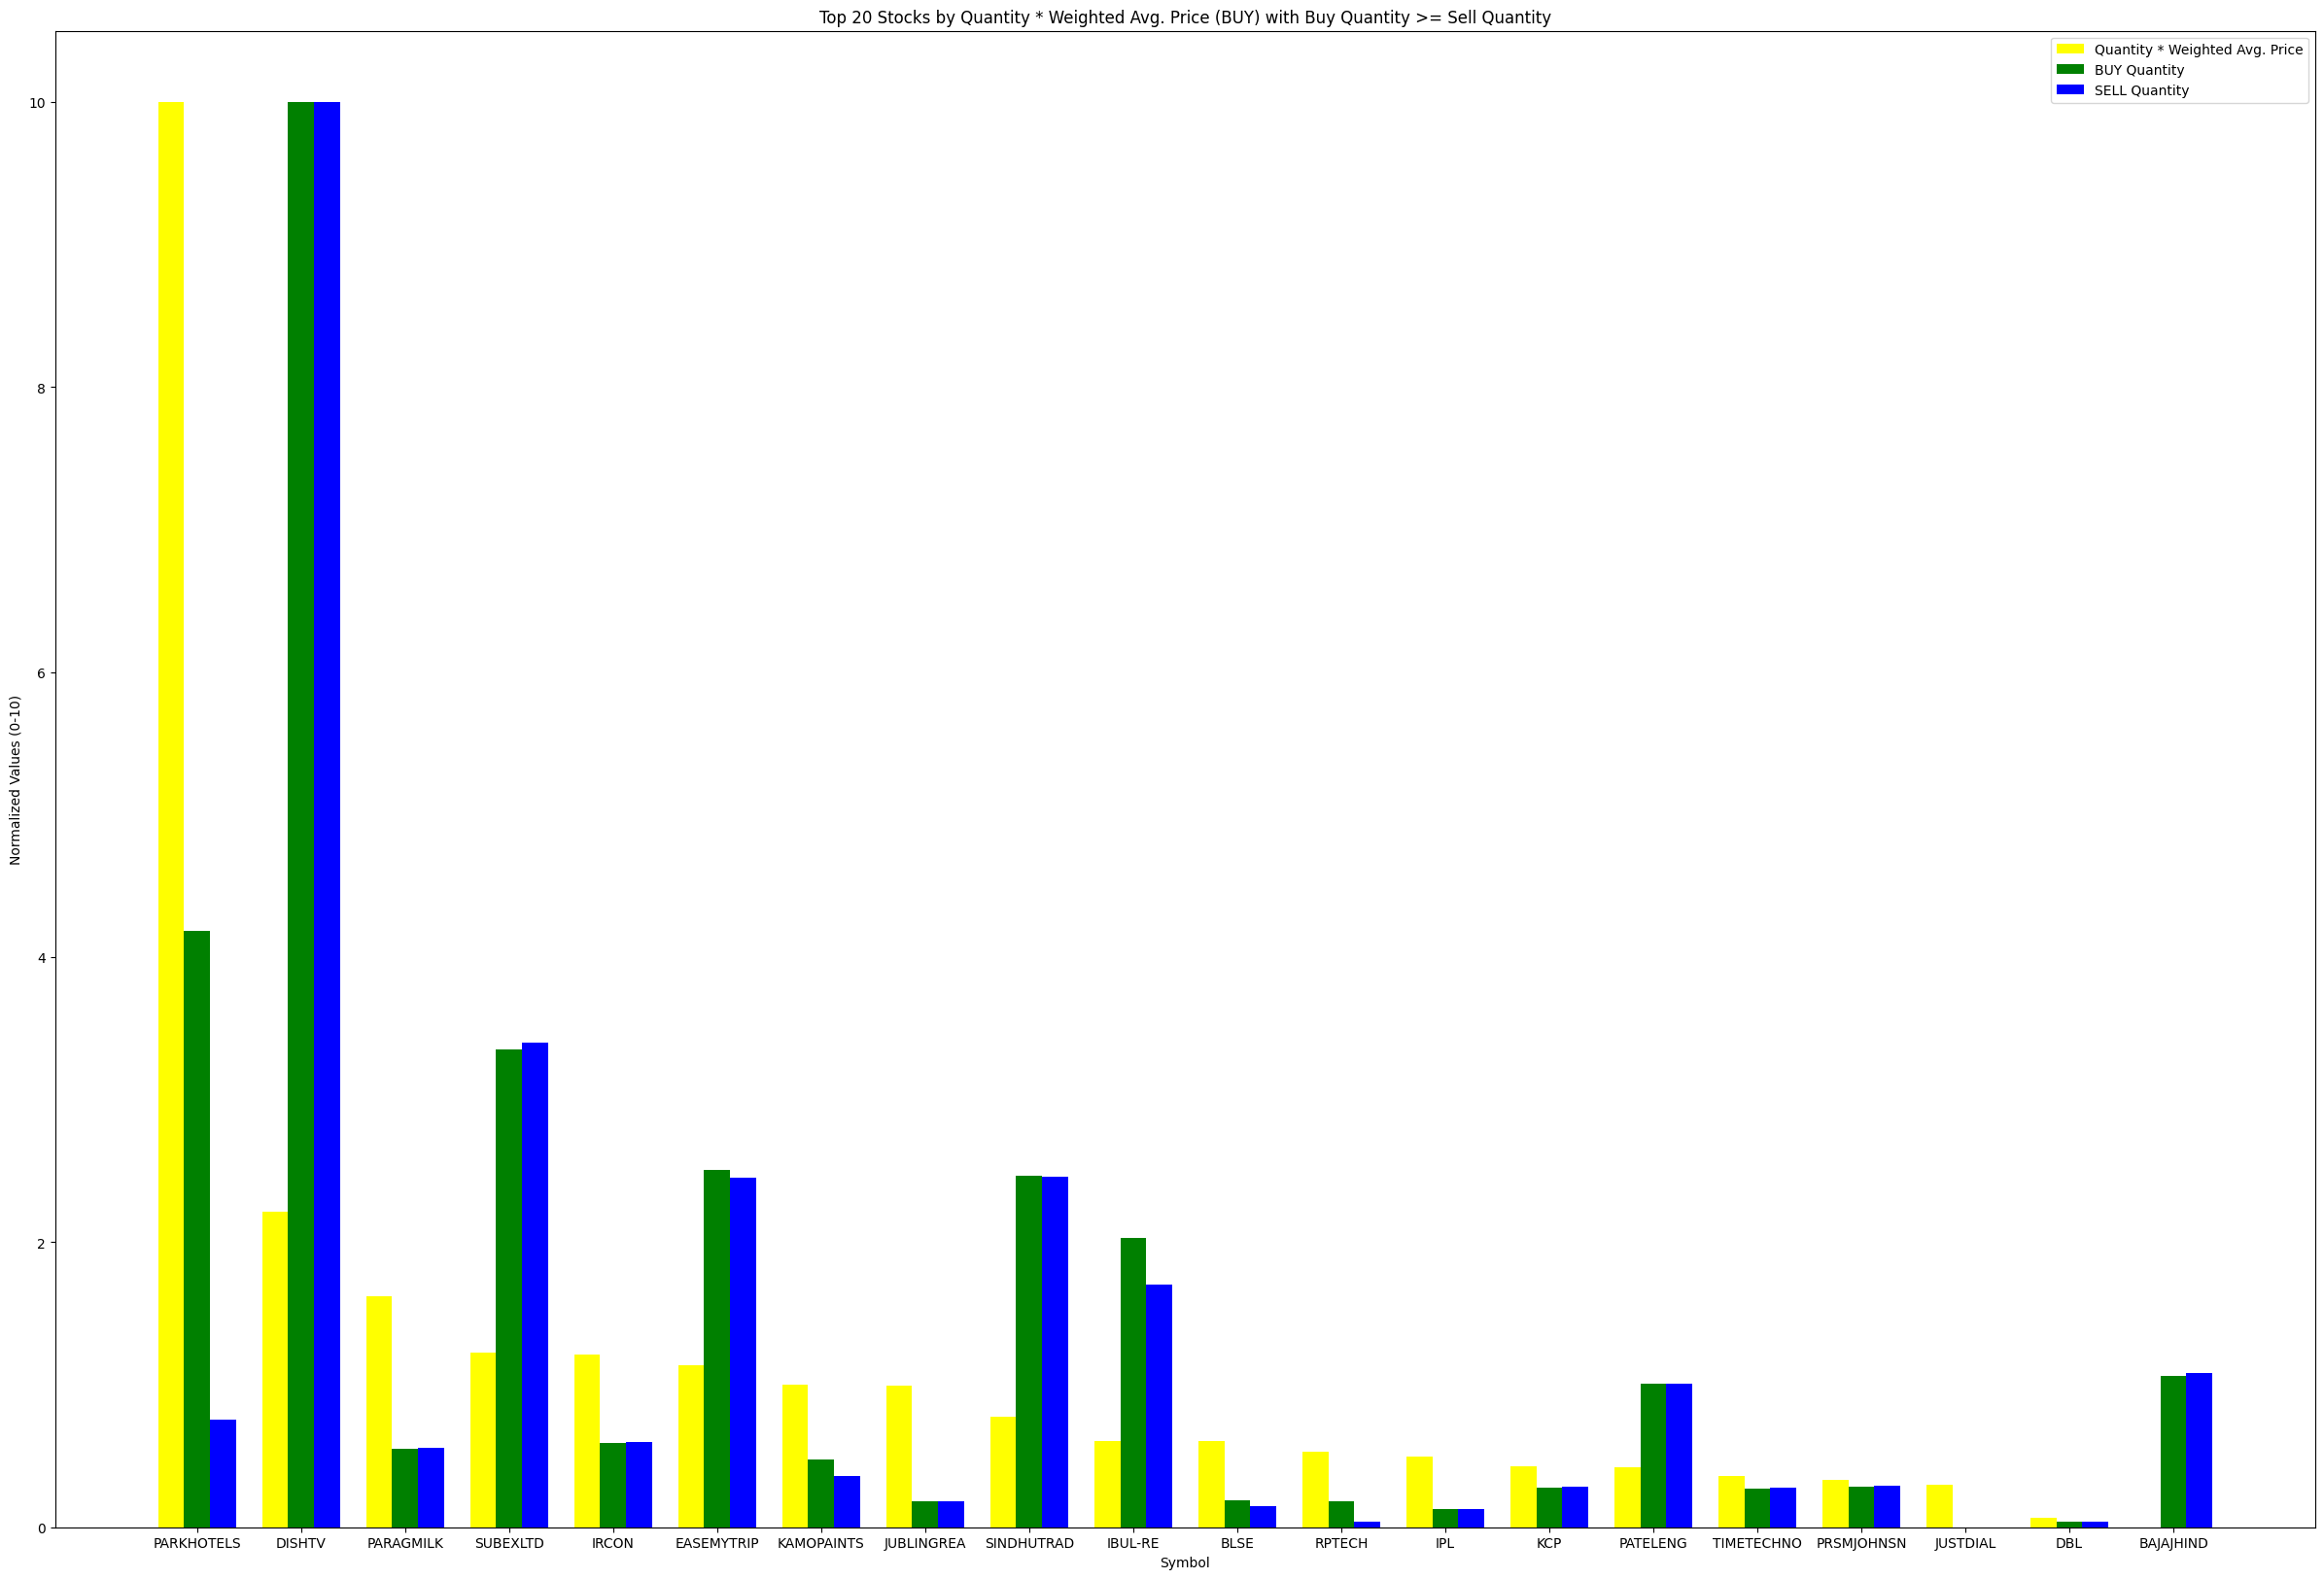

In [10]:
# Plot the triple bar graph
fig, ax = plt.subplots(figsize=(30, 20))
bar_width = 0.25
index = range(len(top_stocks))

# 'Quantity * Weighted Avg. Price' (red bars)
plt.bar(index, normalized_values[:, 0], width=bar_width, label='Quantity * Weighted Avg. Price', color='yellow')

# 'BUY Quantity' (green bars)
plt.bar([i + bar_width for i in index], normalized_values[:, 1], width=bar_width, label='BUY Quantity', color='green')

# 'SELL Quantity' (blue bars)
plt.bar([i + 2 * bar_width for i in index], normalized_values[:, 2], width=bar_width, label='SELL Quantity', color='blue')

plt.xlabel('Symbol')
plt.ylabel('Normalized Values (0-10)')
plt.title(f'Top {top_n_stocks} Stocks by Quantity * Weighted Avg. Price (BUY) with Buy Quantity >= Sell Quantity')
plt.xticks([i + bar_width for i in index], top_stocks['Symbol '])
plt.legend()
plt.show()